# Aprendizaje computacional en grandes volúmenes de texto  

## Mario Graff (mgraffg@ieee.org, mario.graff@infotec.mx)  
## Sabino Miranda (sabino.miranda@infotec.mx)  
## Daniela Moctezuma (dmoctezuma@centrogeo.edu.mx)  
## Eric S. Tellez (eric.tellez@infotec.mx)  
## CONACYT, INFOTEC y CentroGEO
## [https://github.com/ingeotec](https://github.com/ingeotec)

* Aprendizaje supervisado  
  * Modelo general de aprendizaje; Entrenamiento, test, score (accuracy, recall, precision, f1)  
  * Máquinas de soporte vectorial (SVM)  
  * Programación genética (EvoDAG)  
  * Distant supervision  

* $\mu$TC  
  * Pipeline de transformaciones  
  * Optimización de parámetros  
  * Clasificadores  
  * Uso del $\mu$TC  
* Aplicaciones  
  * Análisis de sentimientos  
  * Determinación de autoría  
  * Clasificación de noticias  
  * Spam  
  * Género y edad  
* Conclusiones  


In [145]:
from IPython.core.display import Markdown
docs = ["buen dia microtc", "excelente dia", "odio el trafico",
	"la computadora", "la mesa", "la ventana"]
l = ["* " + x for x in docs]
Markdown("# Corpus\n" + "\n".join(l))

# Corpus
* buen dia microtc
* excelente dia
* odio el trafico
* la computadora
* la mesa
* la ventana

# TFIDF
** buen dia microtc **, **excelente dia**, **odio el trafico**

In [146]:
from microtc.textmodel import TextModel
import numpy as np
import pandas as pd
M = np.zeros((11, len(docs)))
model = TextModel(docs, token_list=[-1])
words = {}
for x in docs:
    for i in x.split(): words[model.dictionary.doc2bow([i])[0][0]] = i
[[M.__setitem__((x[0], k), "%0.4f" % x[1]) for x in model[d]] for k, d in enumerate(docs)]
M = np.concatenate((np.atleast_2d([words[x] for x in range(11)]).T, M), axis=1)
pd.DataFrame(M, columns=['Palabras'] + ["Doc. %s" % (x + 1) for x in range(len(docs))])

,Palabras,Doc. 1,Doc. 2,Doc. 3,Doc. 4,Doc. 5,Doc. 6
0,ventana,0.0,0.0,0.0,0.0,0.0,0.7071
1,odio,0.0,0.0,0.682,0.0,0.0,0.0
2,excelente,0.0,0.5227,0.0,0.0,0.0,0.0
3,dia,0.5774,0.8525,0.0,0.0,0.0,0.0
4,mesa,0.0,0.0,0.0,0.0,0.7071,0.0
5,microtc,0.5774,0.0,0.0,0.0,0.0,0.0
6,trafico,0.0,0.0,0.682,0.0,0.0,0.0
7,computadora,0.0,0.0,0.0,0.7071,0.0,0.0
8,el,0.0,0.0,0.2639,0.0,0.0,0.0
9,buen,0.5774,0.0,0.0,0.0,0.0,0.0


# Aprendizaje Supervisado

* Se tiene un conjunto $T = \{ (x_i, y_i)\}$
* $x$ son las variables independientes, observaciones, ...
* $y$ es la variable dependiente
* objetivo $f(x) \approx y$

In [147]:
import numpy as np
x = np.linspace(-10, 10, 10)
y = x**2 + 12 * x + 3.2 + np.random.uniform(-1, 1, x.shape[0])
pd.DataFrame(np.vstack([x, y]).T, columns=['x', 'y'])


,x,y
0,-10.000000,-16.560799
1,-7.777778,-28.836777
2,-5.555556,-32.602078
3,-3.333333,-25.546278
4,-1.111111,-8.020112
5,1.111111,18.123679
6,3.333333,53.714511
7,5.555556,101.594476
8,7.777778,156.893698
9,10.000000,223.553109


Populating the interactive namespace from numpy and matplotlib


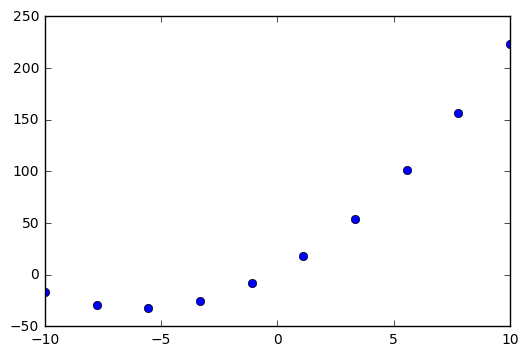

In [148]:
%pylab inline
pylab.plot(x, y, 'o')

# Aprendizaje Supervisado

* suponiendo que $f(x) = a x^2 + b x + c$

## Entrenamiento

* minimizar $\sum_i (y_i - (a x_i^2 + b x_i + c))^2$

In [149]:
import numpy as np
X = np.vstack((x**2, x, np.ones_like(x))).T
coef = np.linalg.lstsq(X, y)[0]
print(coef)

[  1.00034719  11.98922025   3.47645731]


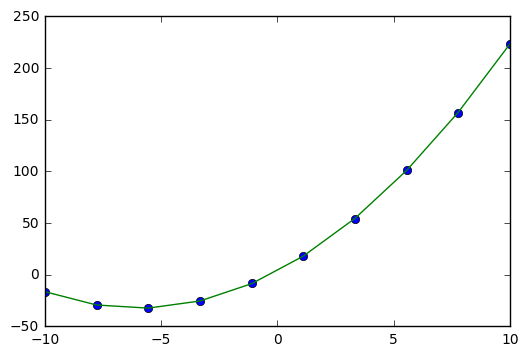

In [150]:
pylab.plot(x, y, 'o')
pylab.plot(x, np.dot(X, coef))

# Aprendizaje Supervisado

## Predicción



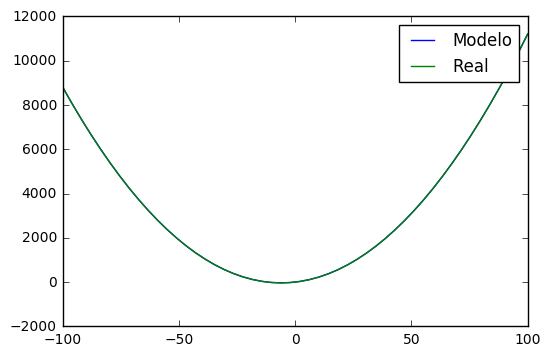

In [151]:
x = np.linspace(-100, 100, 50)
X = np.vstack((x**2, x, np.ones_like(x))).T
pylab.plot(x, np.dot(X, coef))
pylab.plot(x, np.dot(X, np.array([1, 12, 3.2])))
pylab.legend(['Modelo', 'Real'])

# Medidas de rendimiento

* Recall ($r$): Fracción de instancias relevantes recolectadas
* Precision ($p$): fracción de instancias recolectadas relevantes para la consulta
* Score F1 $2 \frac{p \cdot r}{p + r}$

![Precision/Recall](https://upload.wikimedia.org/wikipedia/commons/2/26/Precisionrecall.svg)

# microtc-textModel

```bash
microtc-textModel -m supervised/microtc.model -o supervised/train.textmodel datasets/train.json.gz 
```

```json

{"11268": 0.08856512767171724, "text": "dear @Microsoft the newOoffice for Mac is great and all, but no Lync update? C'mon.", "7686": 0.055381812446489244, "157703": 0.08856512767171724, "330924": 0.08856512767171724, "432651": 0.08856512767171724, "226829": 0.08856512767171724, "435728": 0.08856512767171724, "154130": 0.08856512767171724, "341529": 0.08856512767171724, "80923": 0.07490376701241866, "23586": 0.08856512767171724, "70693": 0.08856512767171724, "376359": 0.08856512767171724, "415788": 0.08856512767171724, "415792": 0.08856512767171724, "198711": 0.08856512767171724, "27316": 0.07490376701241866, "411487": 0.08856512767171724, "39488": 0.05325102265860315, "84036": 0.08856512767171724, "44102": 0.08856512767171724, "109640": 0.08856512767171724, "124698": 0.08856512767171724, "12813": 0.08856512767171724, "268883": 0.08856512767171724, "156247": 0.08856512767171724,..., "num_terms": 464328
 ```

# Distant Supervision

* Etiquetar datos automáticamente
* Uso de heurísticas
* Asumiento que se tiene $K$ conjunto etiquetados
* Solo hay dos clases positivos y negativos
* ¿Cómo entreno? 

 ```bash  
for ds in data/data-*.json.gz;
do
    base=`basename $ds`
    base=distant_supervision/`basename $base .json.gz`
    param=$base.params
    model=$base.model
    predict=$base.predict
    gold=$base.gold
    if [ ! -f $param ]
    then
        microtc-params -o $param -k 0:1 -S avgf1:positive:negative -n 32 -s 32 -H static:$ds datasets/train.json.gz
    fi
    if [ ! -f $model ]
    then
        microtc-train -o $model -m $param $ds
    fi
done
```

## Predecir
 ```bash  
for ds in data/data-*.json.gz;
do
    base=`basename $ds`
    base=distant_supervision/`basename $base .json.gz`
    param=$base.params
    model=$base.model
    predict=$base.predict
    gold=$base.gold
    if [ ! -f $predict ]
    then
        microtc-predict -o $predict -m $model datasets/train.json.gz
    fi

    if [ ! -f $gold ]
    then
        microtc-predict -o $gold -m $model datasets/gold.json.gz
    fi
done  
```

# Ejemplo
```json  
 {"voc_affinity": 0.6414342629482072, "klass": "negative", "id": "628949369883000832", "text": "dear @Microsoft the newOoffice for Mac is great and all, but no Lync update? C'mon.", "decision_function": -0.038332115769748785}
 {"voc_affinity": 0.7912844036697247, "klass": "negative", "id": "628976607420645377", "text": "@Microsoft how about you make a system that doesn't eat my friggin discs. This is the 2nd time this has happened and I am so sick of it!", "decision_function": -0.21017788877835167}
 ```

# Distant Supervision

* $K$ valores de la función de decisión
* Cómo uso el conjunto de entrenamiento

## Método directo
* Uso microtc para predecir el conjunto de entrenamiento
* No se estaría probando la generalidad de microtc 

# Validación cruzada

* Medir la generalidad del modelo
* Generar predicciones de un conjunto de entrenamiento

In [152]:
from sklearn.cross_validation import KFold
l = []
for ts, vs in KFold(10, shuffle=True,
		    random_state=1, n_folds=5):
    a = [list() for i in range(10)]
    [a.__setitem__(x, 'ent.') for x in ts]
    [a.__setitem__(x, 'val.') for x in vs]
    l.append(a)
d = np.array(l).T
pd.DataFrame(d, columns=['Fold %s' % x for x in range(1, 6)])

,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5
0,ent.,ent.,val.,ent.,ent.
1,ent.,ent.,ent.,val.,ent.
2,val.,ent.,ent.,ent.,ent.
3,ent.,ent.,val.,ent.,ent.
4,ent.,val.,ent.,ent.,ent.
5,ent.,ent.,ent.,ent.,val.
6,ent.,val.,ent.,ent.,ent.
7,ent.,ent.,ent.,val.,ent.
8,ent.,ent.,ent.,ent.,val.
9,val.,ent.,ent.,ent.,ent.


# Crear KFold
```python
import sklearn.cross_validation
import gzip
from b4msa.utils import tweet_iterator
from tqdm import tqdm
import json
import sys

D = [x for x in tweet_iterator(sys.argv[1])]

c = 0
for tr, val in sklearn.cross_validation.KFold(len(D), n_folds=10):
    for output, index in zip(['kfolds/train-%s.json.gz' % c,
                              'kfolds/validation-%s.json.gz' % c],
                             [tr, val]):
        with gzip.open(output, 'wb') as fpt:
            for x in tqdm(index):
                fpt.write(bytes(json.dumps(D[x]) + '\n', encoding='UTF-8'))
    c += 1```

# Entrenar y Predecir KFold
```bash  
for i in `seq 0 9`;
do
    base=kfolds/microtc-$i
    param=$base.params
    model=$base.model
    predict=$base.predict
    train=kfolds/train-$i.json.gz
    val=kfolds/validation-$i.json.gz
    if [ ! -f $param ]
    then
        microtc-params -o $param -k 0.7 -n 32 -s 32 -H $train
    fi

    if [ ! -f $model ]
    then
        microtc-train -o $model -m $param $train
    fi

    if [ ! -f $predict ]
    then
        microtc-predict -o $predict -m $model $val
    fi
 done
``` 